# **환경 구성**

In [1]:
# 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 라이브러리 및 gpu 확인
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

tf.random.set_seed(42) # seed 고정
np.random.seed(42)

print("TensorFlow 버전:", tf.__version__)
print("GPU 사용 가능:", tf.config.list_physical_devices('GPU'))

TensorFlow 버전: 2.19.0
GPU 사용 가능: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# **데이터 로드**

In [3]:
def data(dataset_path):
    images = []
    labels = []
    for subfolder in os.listdir(dataset_path):              # 각 클래스 폴더 탐색
        subfolder_path = os.path.join(dataset_path, subfolder)
        if not os.path.isdir(subfolder_path):
            continue
        for image_filename in os.listdir(subfolder_path):   # 각 폴더 내의 .jpg 이미지 탐색
            if image_filename.endswith(".jpg"):
                image_path = os.path.join(subfolder_path, image_filename)
                images.append(image_path)                   # 전체 이미지 경로 리스트 저장
                labels.append(subfolder)                    # 폴더명을 라벨로 저장
    df = pd.DataFrame({'image': images, 'label': labels})   # 이미지 경로와 라벨을 DataFrame으로 정리
    return df

train=data('/content/drive/MyDrive/lumbar_spinal_dataset/training')
test=data('/content/drive/MyDrive/lumbar_spinal_dataset/testing')

train.shape, test.shape

((4808, 2), (1158, 2))

# **EDA**

In [ ]:
# 라벨 확인
print(train['label'].value_counts())
print(test['label'].value_counts())

label
Herniated Disc    1903
No Stenosis       1542
Thecal Sac        1363
Name: count, dtype: int64
label
Thecal Sac        612
No Stenosis       289
Herniated Disc    257
Name: count, dtype: int64


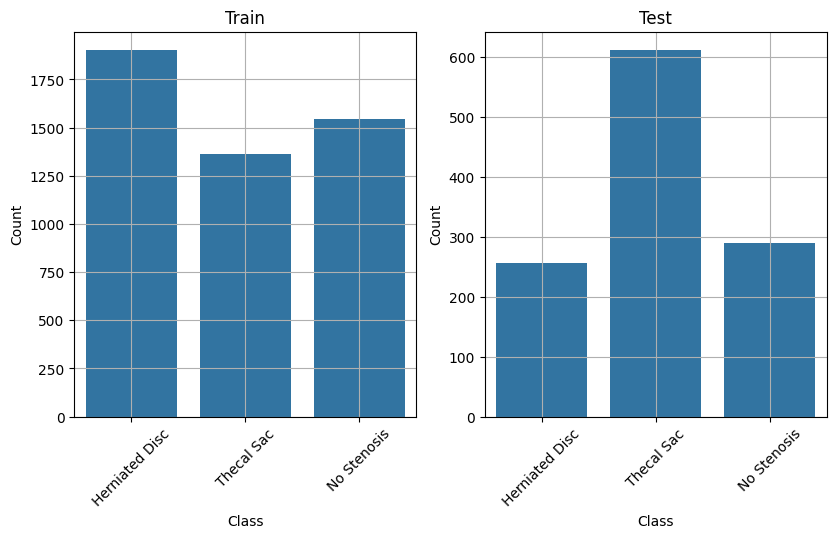

In [ ]:
# 각 split에서의 class balance 확인
plt.figure(figsize=(15,5))
order_list = ["Herniated Disc", "Thecal Sac", "No Stenosis"]

plt.subplot(1,3,1)
ax = sns.countplot(x=train.label, order=order_list)
ax.set_xlabel("Class")
ax.set_ylabel("Count")
plt.title('Train')
plt.grid(True)
plt.xticks(rotation=45)

plt.subplot(1,3,2)
ax = sns.countplot(x=test.label, order=order_list)
ax.set_xlabel("Class")
ax.set_ylabel("Count")
plt.title('Test')
plt.grid(True)
plt.xticks(rotation=45)

plt.show()

In [ ]:
# 이미지 모드 확인
from PIL import Image
train_img = Image.open(train['image'].iloc[0])
test_img = Image.open(test['image'].iloc[0])
print(f"[Train]:{train_img.mode}, [Test]:{test_img.mode}")

[Train]:RGB, [Test]:RGB


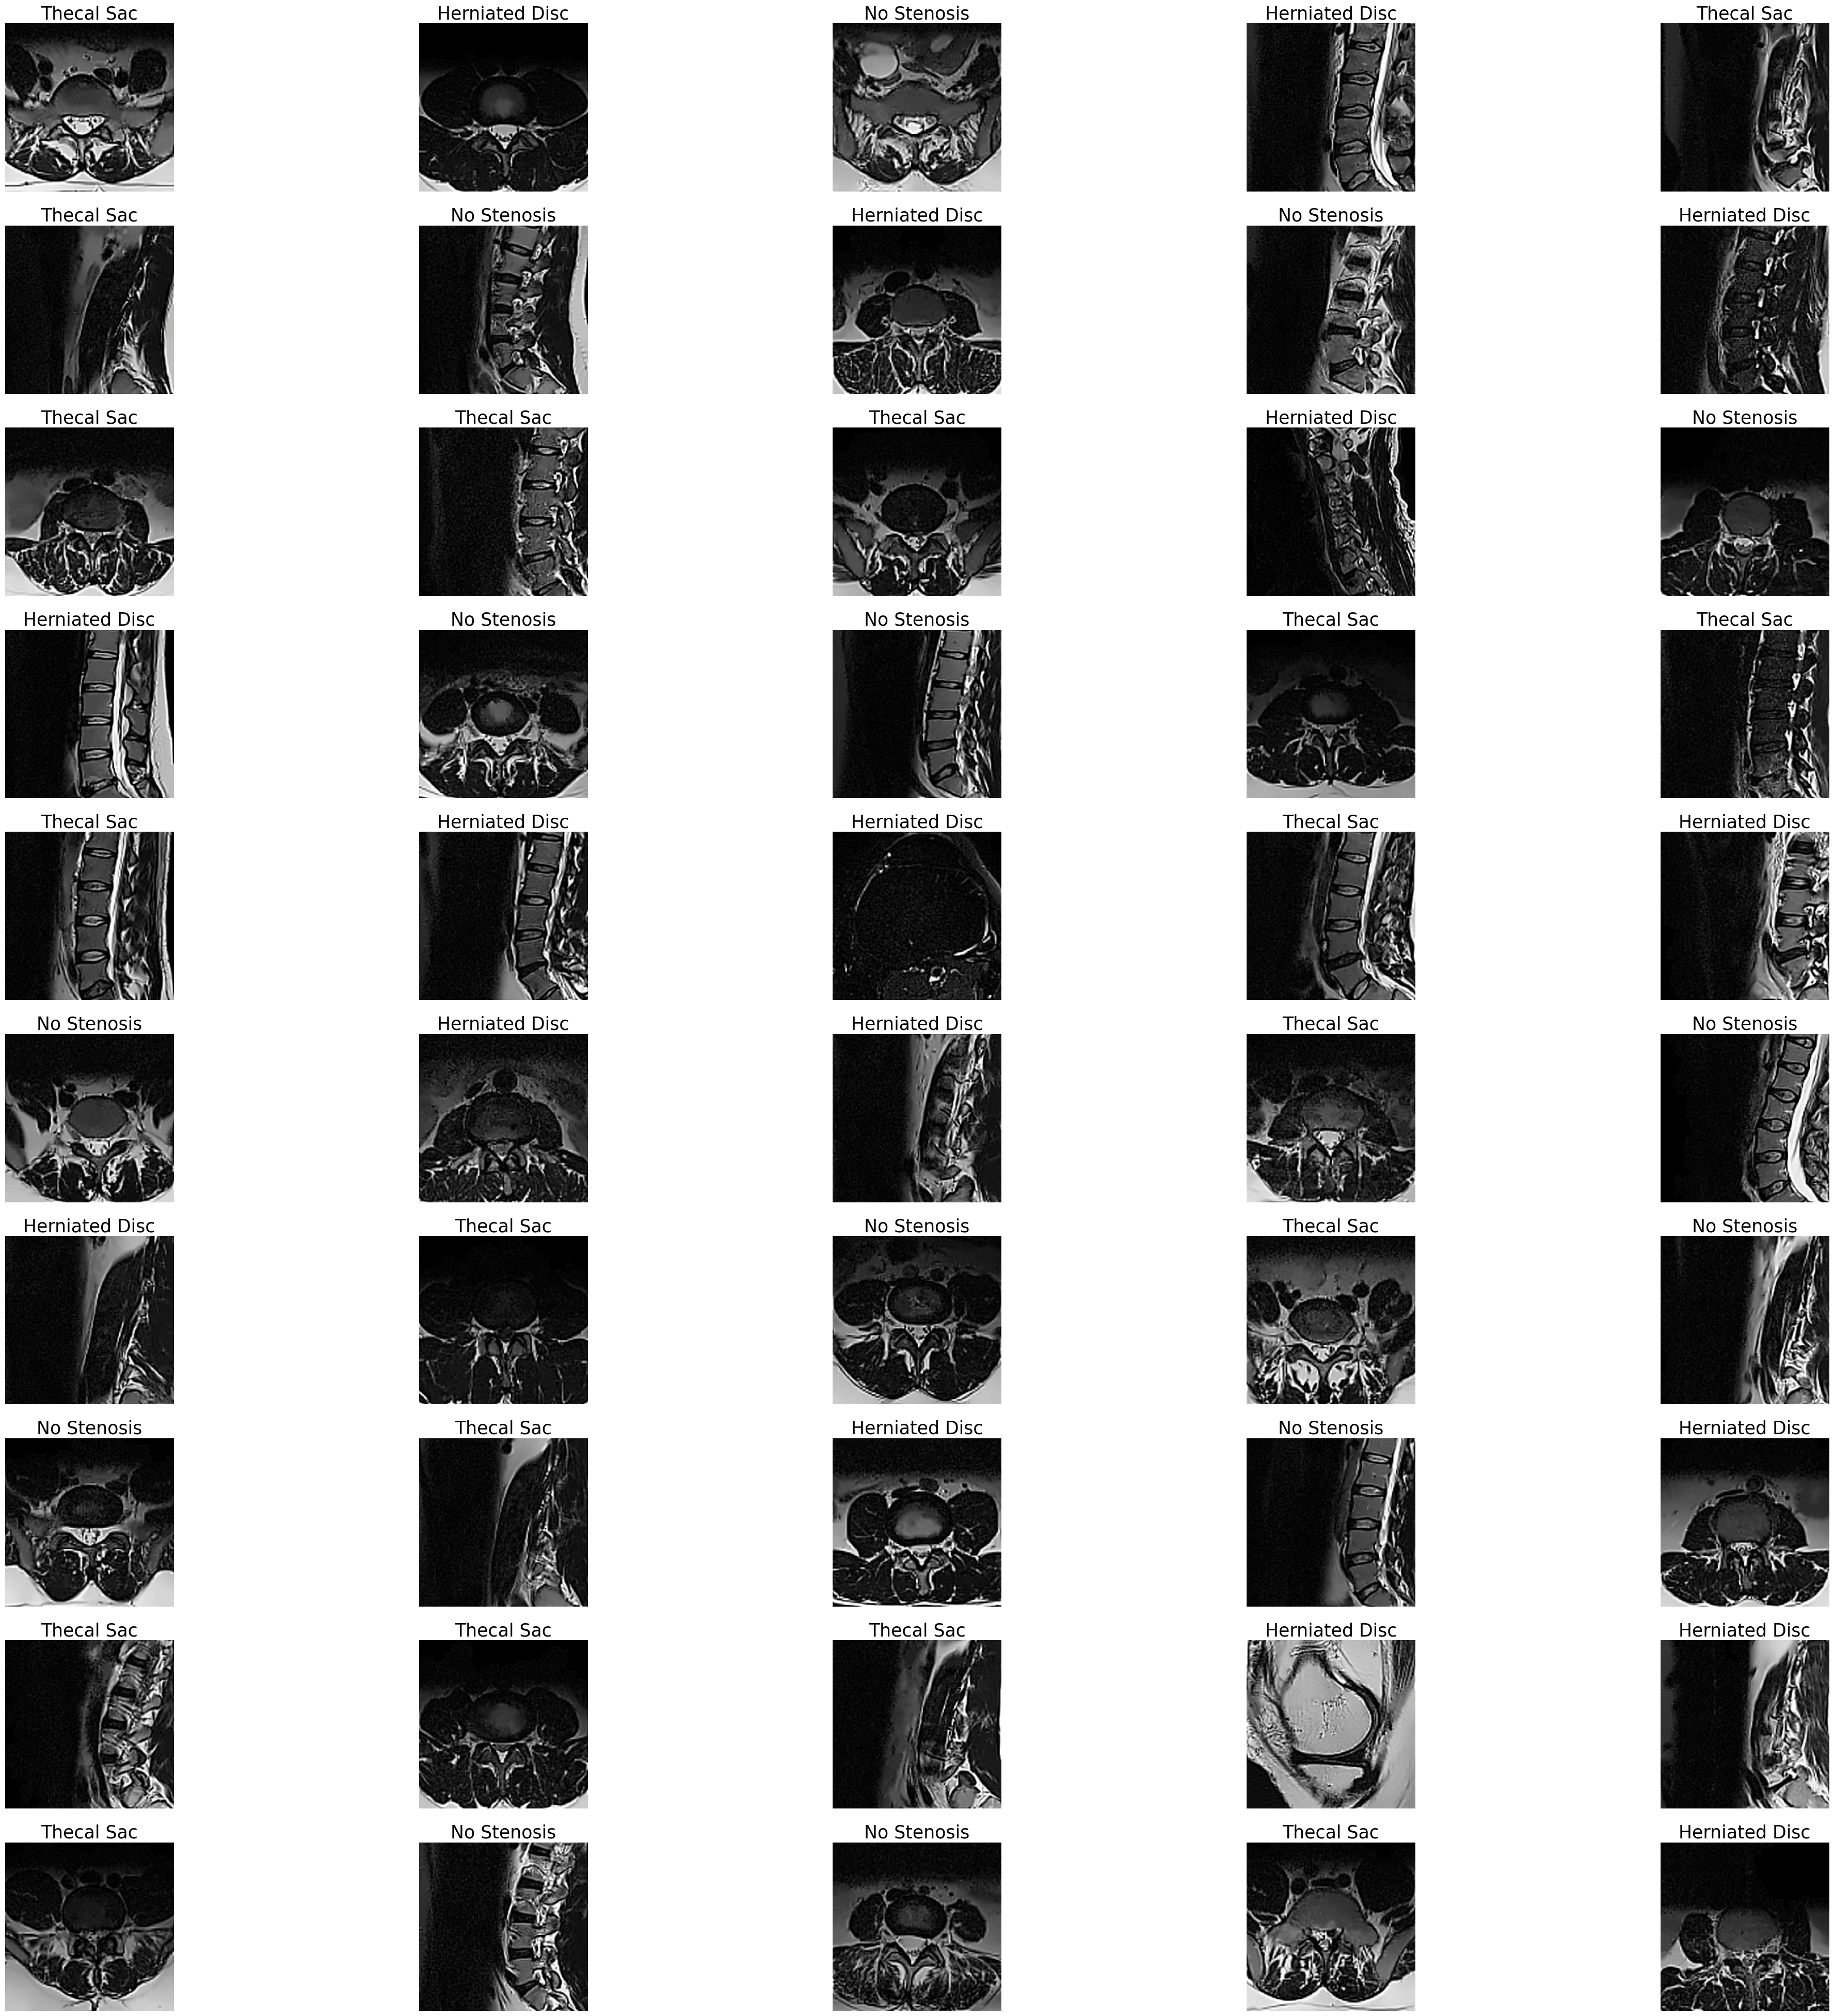

In [ ]:
# class별 random sample 확인
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(train),50)):
    plt.subplot(10,5,n+1)
    img=cv2.imread(train.image[i])
    plt.imshow(img)
    plt.axis('off')
    plt.title(train.label[i],fontsize=25)

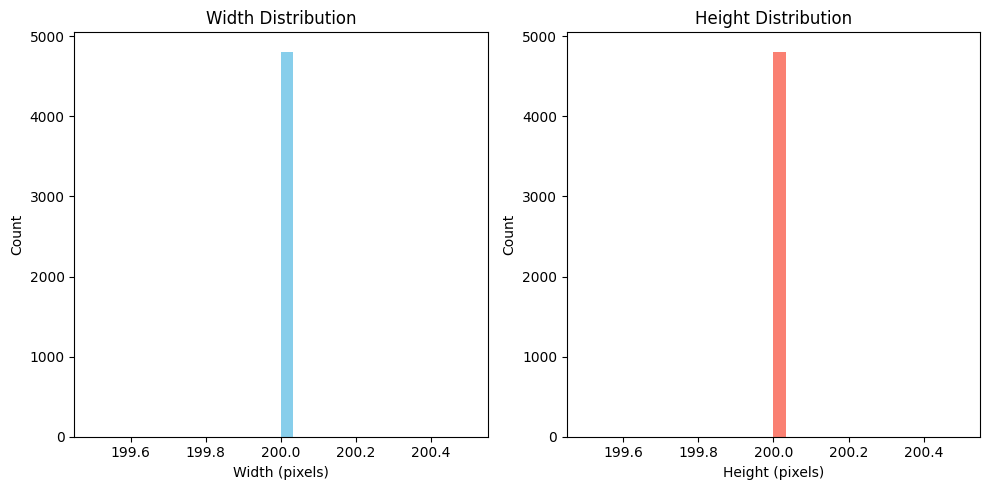

In [ ]:
#해상도 확인(train)
widths, heights = [], []

for path in train["image"]:
    img = cv2.imread(path)
    if img is None:
        print(f"⚠️ 이미지 로드 실패: {path}")
        continue
    h, w = img.shape[:2]
    widths.append(w)
    heights.append(h)

# 시각화
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.hist(widths, bins=30, color='skyblue')
plt.title('Width Distribution')
plt.xlabel('Width (pixels)')
plt.ylabel('Count')

plt.subplot(1,2,2)
plt.hist(heights, bins=30, color='salmon')
plt.title('Height Distribution')
plt.xlabel('Height (pixels)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


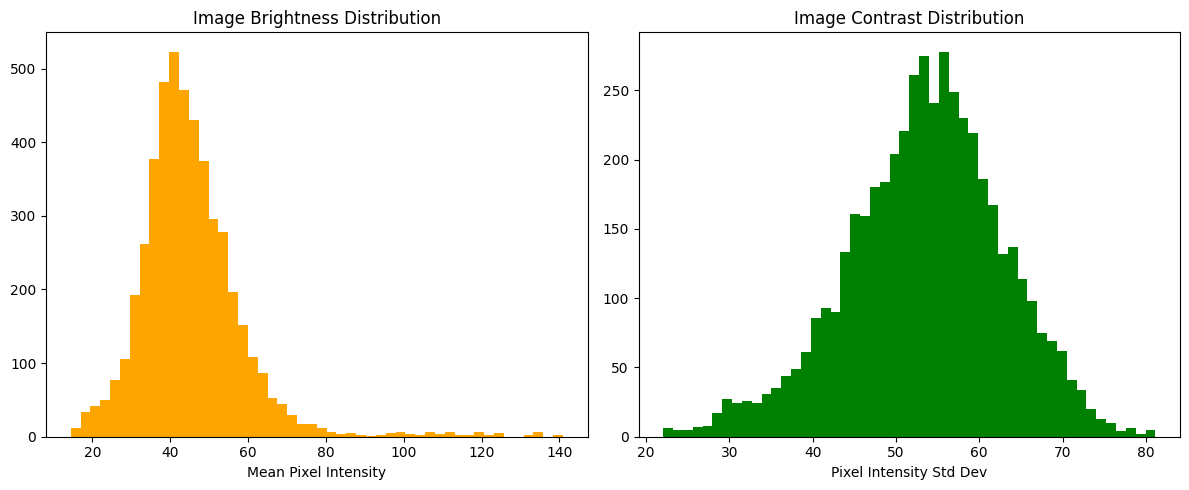

In [ ]:
#밝기 & 대비 확인
brightness = []
contrast = []

for path in train["image"]:
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # 흑백 기준
    if img is None:
        continue
    brightness.append(np.mean(img))
    contrast.append(np.std(img))  # 대비 = 표준편차

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(brightness, bins=50, color='orange')
plt.title("Image Brightness Distribution")
plt.xlabel("Mean Pixel Intensity")

plt.subplot(1,2,2)
plt.hist(contrast, bins=50, color='green')
plt.title("Image Contrast Distribution")
plt.xlabel("Pixel Intensity Std Dev")

plt.tight_layout()
plt.show()

# **CNN**

In [6]:
# 이미지 전처리
image_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,          # 정규화
    rotation_range=10,       # ±10도 회전
    width_shift_range=0.1,   # 가로 이동 ±10%
    height_shift_range=0.1,  # 세로 이동 ±10%
    zoom_range=0.1,          # 확대/축소 ±10%
    brightness_range=(0.9, 1.1),  # 밝기 변화 (90~110%)
    fill_mode="nearest"      # 증강 시 생기는 빈 공간 채우기
)
datagen = ImageDataGenerator(rescale=1./255)

# train 데이터의 일부를 validation 데이터로 사용
train_df, val_df = train_test_split(train, test_size=0.2, stratify=train['label'], random_state=42)

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = datagen.flow_from_dataframe(
    val_df,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_gen = datagen.flow_from_dataframe(
    test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 3846 validated image filenames belonging to 3 classes.
Found 962 validated image filenames belonging to 3 classes.
Found 1158 validated image filenames belonging to 3 classes.


In [ ]:
# baseline
class_num=3
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3),activation=tf.nn.relu,input_shape=(224,224,3)))
model.add(keras.layers.MaxPool2D((2,2)))
model.add(keras.layers.Conv2D(filters=64, kernel_size=(3,3),activation=tf.nn.relu))
model.add(keras.layers.MaxPool2D((2,2)))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Conv2D(filters=128, kernel_size=(3,3),activation=tf.nn.relu))
model.add(keras.layers.MaxPool2D((2,2)))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.GlobalAveragePooling2D())
model.add(keras.layers.Dense(128,activation=tf.nn.relu))
model.add(keras.layers.Dropout(.5))
model.add(keras.layers.Dense(class_num,activation=tf.nn.softmax))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,147 (430.26 KB)

 Trainable params: 110,147 (430.26 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
checkpoint_cb =ModelCheckpoint("best_model.h5",monitor='val_loss',save_best_only=True,mode='min',)
early_stopping_cb =EarlyStopping(patience=5, restore_best_weights=True)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
hist=model.fit(train_gen,epochs=10,validation_data=val_gen,callbacks=[checkpoint_cb,early_stopping_cb])

Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3777 - loss: 1.0948

121/121 ━━━━━━━━━━━━━━━━━━━━ 485s 4s/step - accuracy: 0.3778 - loss: 1.0948 - val_accuracy: 0.3973 - val_loss: 1.0892
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3850 - loss: 1.0926

121/121 ━━━━━━━━━━━━━━━━━━━━ 468s 4s/step - accuracy: 0.3850 - loss: 1.0926 - val_accuracy: 0.3973 - val_loss: 1.0883
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 466s 4s/step - accuracy: 0.4072 - loss: 1.0862 - val_accuracy: 0.3973 - val_loss: 1.0888
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 466s 4s/step - accuracy: 0.3990 - loss: 1.0888 - val_accuracy: 0.3973 - val_loss: 1.0886
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 466s 4s/step - accuracy: 0.4000 - loss: 1.0859 - val_accuracy: 0.3973 - val_loss: 1.0885
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3940 - loss: 1.0885

121/121 ━━━━━━━━━━━━━━━━━━━━ 466s 4s/step - accuracy: 0.3940 - loss: 1.0885 - val_accuracy: 0.3973 - val_loss: 1.0880
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3946 - loss: 1.0880

121/121 ━━━━━━━━━━━━━━━━━━━━ 474s 4s/step - accuracy: 0.3946 - loss: 1.0880 - val_accuracy: 0.3973 - val_loss: 1.0876
Epoch 8/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 466s 4s/step - accuracy: 0.3991 - loss: 1.0877 - val_accuracy: 0.3973 - val_loss: 1.0878
Epoch 9/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3919 - loss: 1.0900

121/121 ━━━━━━━━━━━━━━━━━━━━ 468s 4s/step - accuracy: 0.3919 - loss: 1.0900 - val_accuracy: 0.3973 - val_loss: 1.0869
Epoch 10/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 469s 4s/step - accuracy: 0.4018 - loss: 1.0868 - val_accuracy: 0.3973 - val_loss: 1.0874


In [ ]:
hist_ = pd.DataFrame(hist.history)
hist_

accuracy      loss  val_accuracy  val_loss
0  0.386092  1.091501      0.397303  1.089165
1  0.395433  1.090190      0.397303  1.088324
2  0.397509  1.089180      0.397303  1.088788
3  0.396990  1.088434      0.397303  1.088586
4  0.397250  1.088869      0.397303  1.088467
5  0.396990  1.087885      0.397303  1.087975
6  0.398806  1.086919      0.397303  1.087619
7  0.399325  1.088587      0.397303  1.087776
8  0.400363  1.088193      0.397303  1.086892
9  0.398806  1.087863      0.397303  1.087383

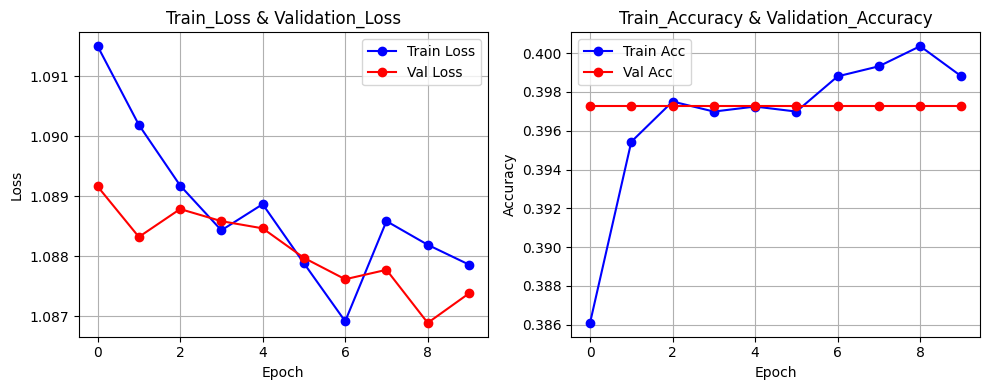

In [ ]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(hist.history['loss'], 'b-o', label='Train Loss')
plt.plot(hist.history['val_loss'], 'r-o', label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Train_Loss & Validation_Loss')
plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'], 'b-o', label='Train Acc')
plt.plot(hist.history['val_accuracy'], 'r-o', label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Train_Accuracy & Validation_Accuracy')
plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
results = model.evaluate(test_gen, return_dict=True, verbose=1)
auc_key = next((k for k in results.keys() if k.startswith('auc')), None)

print(f"Test Loss = {results['loss']}")
print(f"Test Accuracy = {results['accuracy']}")
if auc_key is not None:
  print(f"Test AUC = {results['auc_key']}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


37/37 ━━━━━━━━━━━━━━━━━━━━ 285s 8s/step - accuracy: 0.5301 - loss: 1.0551
Test Loss = 1.1574064493179321
Test Accuracy = 0.22193436324596405


In [ ]:
# 예측 결과
y_probs = model.predict(test_gen)
y_pred = np.argmax(y_probs, axis=1)
y_true = test_gen.classes
class_names = list(test_gen.class_indices.keys())

# f1 score
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

print(f"F1 Macro : {f1_macro:.4f}")
print(f"F1 Weighted : {f1_weighted:.4f}")

# classification report
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

37/37 ━━━━━━━━━━━━━━━━━━━━ 35s 929ms/step
F1 Macro : 0.1211
F1 Weighted : 0.0806
                precision    recall  f1-score   support

Herniated Disc     0.2219    1.0000    0.3633       257
   No Stenosis     0.0000    0.0000    0.0000       289
    Thecal Sac     0.0000    0.0000    0.0000       612

      accuracy                         0.2219      1158
     macro avg     0.0740    0.3333    0.1211      1158
  weighted avg     0.0493    0.2219    0.0806      1158



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


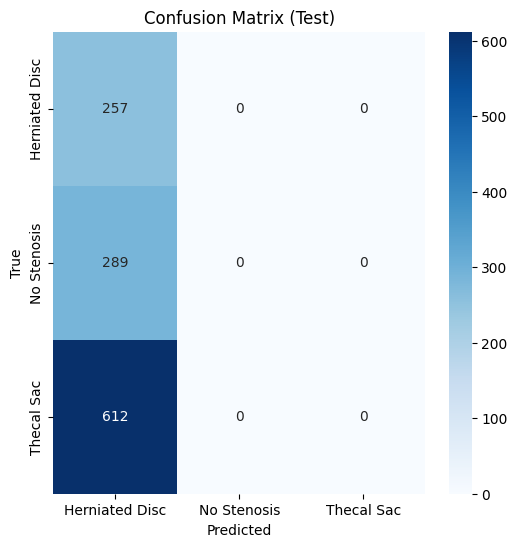

In [ ]:
# 혼동행렬
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Test)")
plt.show()

In [ ]:
# 이미지 경로 추출
image_paths = test['image'].tolist()

# 샘플 시각화
plt.figure(figsize=(15, 5))
for n, i in enumerate(np.random.randint(0, len(test), 50)):
    # 이미지 불러오기
    img = plt.imread(image_paths[i])

    # 시각화
    plt.subplot(5, 10, n + 1)
    plt.imshow(img)
    plt.axis('off')

    # 정답/예측 표시
    true_label = class_names[y_true[i]]
    pred_label = class_names[y_pred[i]]

    color = 'green' if true_label == pred_label else 'red'
    plt.title(f'{pred_label}', color=color)

plt.tight_layout()
plt.show()

# **VGG**

In [4]:
# VGG
class_num = 3
model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(224,224,3)),
    keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    keras.layers.MaxPool2D((2,2)),

    keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    keras.layers.MaxPool2D((2,2)),

    keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    keras.layers.MaxPool2D((2,2)),

    GlobalAveragePooling2D(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(class_num, activation='softmax')
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 320,803 (1.22 MB)

 Trainable params: 320,803 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# class_weight 보정
# class_weights = compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(train_df['label']),
#     y=train_df['label']
# )
class_weights = {0: 0.6, 1: 1.0, 2: 1.8} # 1번 이외 클래스의 비중을 높임
print(class_weights)

{0: 0.6, 1: 1.0, 2: 1.8}


In [10]:
checkpoint_cb =ModelCheckpoint("best_model.h5",monitor='val_loss',save_best_only=True,mode='min',)
early_stopping_cb =EarlyStopping(patience=5, restore_best_weights=True)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
hist=model.fit(train_gen,epochs=10,validation_data=val_gen,class_weight=class_weights,callbacks=[checkpoint_cb,early_stopping_cb])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2844 - loss: 1.1427

121/121 ━━━━━━━━━━━━━━━━━━━━ 967s 8s/step - accuracy: 0.2844 - loss: 1.1426 - val_accuracy: 0.2838 - val_loss: 1.1867
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.2842 - loss: 1.1295

121/121 ━━━━━━━━━━━━━━━━━━━━ 66s 547ms/step - accuracy: 0.2841 - loss: 1.1295 - val_accuracy: 0.2838 - val_loss: 1.1840
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.2912 - loss: 1.1267

121/121 ━━━━━━━━━━━━━━━━━━━━ 68s 562ms/step - accuracy: 0.2912 - loss: 1.1267 - val_accuracy: 0.2838 - val_loss: 1.1536
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 79s 542ms/step - accuracy: 0.2793 - loss: 1.1244 - val_accuracy: 0.2838 - val_loss: 1.2141
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 68s 560ms/step - accuracy: 0.2855 - loss: 1.1278 - val_accuracy: 0.2838 - val_loss: 1.1898
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 67s 551ms/step - accuracy: 0.2850 - loss: 1.1235 - val_accuracy: 0.2838 - val_loss: 1.1945
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 80s 538ms/step - accuracy: 0.2755 - loss: 1.1235 - val_accuracy: 0.2838 - val_loss: 1.2477
Epoch 8/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 66s 546ms/step - accuracy: 0.2894 - loss: 1.1182 - val_accuracy: 0.2838 - val_loss: 1.1887


In [11]:
checkpoint_cb =ModelCheckpoint("best_model.h5",monitor='val_loss',save_best_only=True,mode='min',)
early_stopping_cb =EarlyStopping(patience=5, restore_best_weights=True)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
hist=model.fit(train_gen,epochs=10,validation_data=val_gen,callbacks=[checkpoint_cb,early_stopping_cb])

Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - accuracy: 0.3178 - loss: 1.1130

121/121 ━━━━━━━━━━━━━━━━━━━━ 78s 607ms/step - accuracy: 0.3181 - loss: 1.1129 - val_accuracy: 0.3960 - val_loss: 1.0886
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 72s 593ms/step - accuracy: 0.3765 - loss: 1.0927 - val_accuracy: 0.3960 - val_loss: 1.0927
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.4022 - loss: 1.0868

121/121 ━━━━━━━━━━━━━━━━━━━━ 66s 543ms/step - accuracy: 0.4022 - loss: 1.0868 - val_accuracy: 0.3960 - val_loss: 1.0871
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 67s 556ms/step - accuracy: 0.3898 - loss: 1.0931 - val_accuracy: 0.3960 - val_loss: 1.0872
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 68s 558ms/step - accuracy: 0.4012 - loss: 1.0883 - val_accuracy: 0.3960 - val_loss: 1.0883
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.4104 - loss: 1.0863

121/121 ━━━━━━━━━━━━━━━━━━━━ 66s 544ms/step - accuracy: 0.4102 - loss: 1.0863 - val_accuracy: 0.3960 - val_loss: 1.0870
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.3964 - loss: 1.0896

121/121 ━━━━━━━━━━━━━━━━━━━━ 66s 547ms/step - accuracy: 0.3964 - loss: 1.0896 - val_accuracy: 0.3960 - val_loss: 1.0870
Epoch 8/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 65s 540ms/step - accuracy: 0.3950 - loss: 1.0881 - val_accuracy: 0.3960 - val_loss: 1.0872
Epoch 9/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.3903 - loss: 1.0907

121/121 ━━━━━━━━━━━━━━━━━━━━ 67s 554ms/step - accuracy: 0.3903 - loss: 1.0907 - val_accuracy: 0.3960 - val_loss: 1.0869
Epoch 10/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 67s 553ms/step - accuracy: 0.3951 - loss: 1.0879 - val_accuracy: 0.3960 - val_loss: 1.0880


In [12]:
hist_ = pd.DataFrame(hist.history)
hist_

accuracy      loss  val_accuracy  val_loss
0  0.357514  1.100185       0.39605  1.088566
1  0.393396  1.089504       0.39605  1.092680
2  0.395736  1.089060       0.39605  1.087106
3  0.395476  1.090183       0.39605  1.087154
4  0.395476  1.088937       0.39605  1.088265
5  0.395736  1.089597       0.39605  1.087032
6  0.395736  1.089461       0.39605  1.087024
7  0.395216  1.089800       0.39605  1.087202
8  0.395736  1.089409       0.39605  1.086943
9  0.395736  1.088933       0.39605  1.087990

In [13]:
results = model.evaluate(test_gen, return_dict=True, verbose=1)
auc_key = next((k for k in results.keys() if k.startswith('auc')), None)

print(f"Test Loss = {results['loss']}")
print(f"Test Accuracy = {results['accuracy']}")
if auc_key is not None:
  print(f"Test AUC = {results['auc_key']}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


37/37 ━━━━━━━━━━━━━━━━━━━━ 201s 6s/step - accuracy: 0.0389 - loss: 1.2312
Test Loss = 1.1557722091674805
Test Accuracy = 0.22193436324596405


In [ ]:
# 예측 결과
y_probs = model.predict(test_gen)
y_pred = np.argmax(y_probs, axis=1)
y_true = test_gen.classes
class_names = list(test_gen.class_indices.keys())

# f1 score
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

print(f"F1 Macro : {f1_macro:.4f}")
print(f"F1 Weighted : {f1_weighted:.4f}")

# classification report
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step
F1 Macro : 0.1211
F1 Weighted : 0.0806
                precision    recall  f1-score   support

Herniated Disc     0.2219    1.0000    0.3633       257
   No Stenosis     0.0000    0.0000    0.0000       289
    Thecal Sac     0.0000    0.0000    0.0000       612

      accuracy                         0.2219      1158
     macro avg     0.0740    0.3333    0.1211      1158
  weighted avg     0.0493    0.2219    0.0806      1158



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


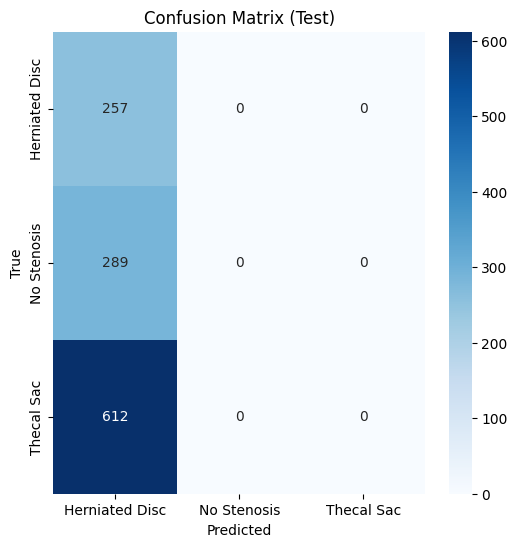

In [ ]:
# 혼동행렬
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Test)")
plt.show()

# **EfficientNetB7**

In [16]:
from tensorflow.keras.applications import EfficientNetB7

class_num = 3
base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = keras.models.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(class_num, activation='softmax')
])

model.summary()


258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)     │ (None, 7, 7, 2560)     │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2560)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     1,311,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,410,458 (249.52 MB)

 Trainable params: 65,099,731 (248.34 MB)

 Non-trainable params: 310,727 (1.19 MB)

In [17]:
checkpoint_cb =ModelCheckpoint("best_model.h5",monitor='val_loss',save_best_only=True,mode='min',)
early_stopping_cb =EarlyStopping(patience=5, restore_best_weights=True)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
hist=model.fit(train_gen,epochs=10,validation_data=val_gen,callbacks=[checkpoint_cb,early_stopping_cb])

Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3970 - loss: 1.0900

121/121 ━━━━━━━━━━━━━━━━━━━━ 515s 2s/step - accuracy: 0.3974 - loss: 1.0896 - val_accuracy: 0.3960 - val_loss: 1.1225
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 875ms/step - accuracy: 0.5625 - loss: 0.9049

121/121 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.5625 - loss: 0.9047 - val_accuracy: 0.3472 - val_loss: 1.1034
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 114s 937ms/step - accuracy: 0.7002 - loss: 0.6992 - val_accuracy: 0.3503 - val_loss: 1.1493
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 885ms/step - accuracy: 0.7925 - loss: 0.5096

121/121 ━━━━━━━━━━━━━━━━━━━━ 175s 1s/step - accuracy: 0.7925 - loss: 0.5096 - val_accuracy: 0.5218 - val_loss: 1.0870
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 113s 933ms/step - accuracy: 0.8669 - loss: 0.3413 - val_accuracy: 0.4802 - val_loss: 1.2989
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 142s 934ms/step - accuracy: 0.9035 - loss: 0.2777 - val_accuracy: 0.5021 - val_loss: 1.2451
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 142s 935ms/step - accuracy: 0.9193 - loss: 0.2105 - val_accuracy: 0.3690 - val_loss: 1.3390
Epoch 8/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 113s 931ms/step - accuracy: 0.9320 - loss: 0.1790 - val_accuracy: 0.3690 - val_loss: 1.3755
Epoch 9/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 116s 956ms/step - accuracy: 0.9497 - loss: 0.1332 - val_accuracy: 0.4626 - val_loss: 1.5173


In [18]:
hist_ = pd.DataFrame(hist.history)
hist_

accuracy      loss  val_accuracy  val_loss
0  0.447998  1.050017      0.396050  1.122520
1  0.569943  0.886239      0.347193  1.103365
2  0.711908  0.686501      0.350312  1.149296
3  0.790952  0.513204      0.521830  1.087040
4  0.866875  0.344172      0.480249  1.298898
5  0.898336  0.282316      0.502079  1.245095
6  0.920957  0.212392      0.369023  1.338988
7  0.939418  0.169143      0.369023  1.375548
8  0.946958  0.139982      0.462578  1.517294

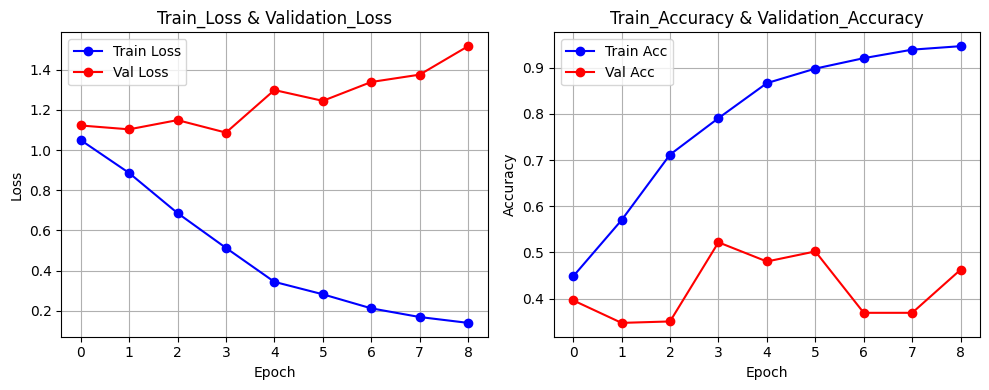

In [19]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(hist.history['loss'], 'b-o', label='Train Loss')
plt.plot(hist.history['val_loss'], 'r-o', label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Train_Loss & Validation_Loss')
plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'], 'b-o', label='Train Acc')
plt.plot(hist.history['val_accuracy'], 'r-o', label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Train_Accuracy & Validation_Accuracy')
plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()

In [20]:
results = model.evaluate(test_gen, return_dict=True, verbose=1)
auc_key = next((k for k in results.keys() if k.startswith('auc')), None)

print(f"Test Loss = {results['loss']}")
print(f"Test Accuracy = {results['accuracy']}")
if auc_key is not None:
  print(f"Test AUC = {results['auc_key']}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 16s 435ms/step - accuracy: 0.4823 - loss: 1.1290
Test Loss = 1.3324289321899414
Test Accuracy = 0.4257340133190155


In [ ]:
# 예측 결과
y_probs = model.predict(test_gen)
y_pred = np.argmax(y_probs, axis=1)
y_true = test_gen.classes
class_names = list(test_gen.class_indices.keys())

# f1 score
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

print(f"F1 Macro : {f1_macro:.4f}")
print(f"F1 Weighted : {f1_weighted:.4f}")

# classification report
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

37/37 ━━━━━━━━━━━━━━━━━━━━ 41s 675ms/step
F1 Macro : 0.3909
F1 Weighted : 0.4287
                precision    recall  f1-score   support

Herniated Disc     0.2865    0.3969    0.3328       257
   No Stenosis     0.3593    0.2872    0.3192       289
    Thecal Sac     0.5394    0.5033    0.5207       612

      accuracy                         0.4257      1158
     macro avg     0.3951    0.3958    0.3909      1158
  weighted avg     0.4383    0.4257    0.4287      1158



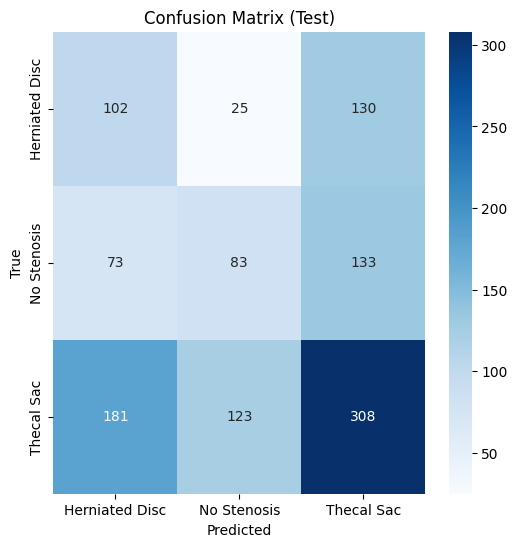

In [ ]:
# 혼동행렬 
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Test)")
plt.show()

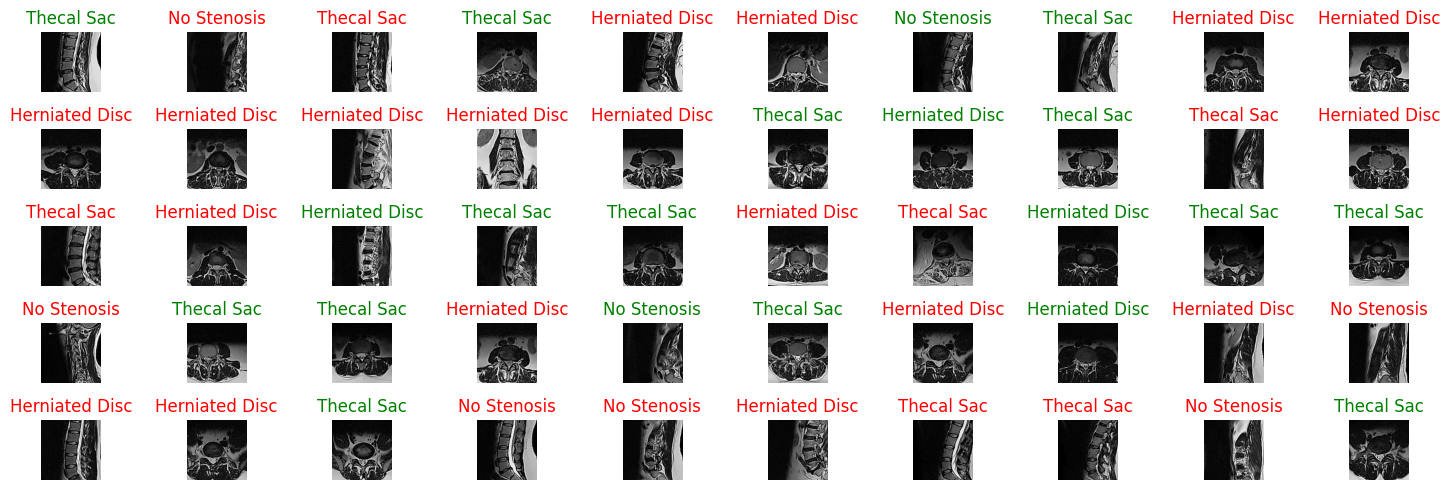

In [23]:
# 이미지 경로 추출
image_paths = test['image'].tolist()

# 샘플 시각화
plt.figure(figsize=(15, 5))
for n, i in enumerate(np.random.randint(0, len(test), 50)):
    # 이미지 불러오기
    img = plt.imread(image_paths[i])

    # 시각화
    plt.subplot(5, 10, n + 1)
    plt.imshow(img)
    plt.axis('off')

    # 정답/예측 표시
    true_label = class_names[y_true[i]]
    pred_label = class_names[y_pred[i]]

    color = 'green' if true_label == pred_label else 'red'
    plt.title(f'{pred_label}', color=color)

plt.tight_layout()
plt.show()